In [1]:
import numpy as np
from siamese.dataset import DataLoader
from siamese.dataset import Dataset
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import os
from sklearn import metrics
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
print("Training set (images) shape: {shape}".format(shape=x_train.shape))
print("Training set (labels) shape: {shape}".format(shape=y_train.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=x_test.shape))
print("Test set (labels) shape: {shape}".format(shape=y_test.shape))

Training set (images) shape: (60000, 28, 28)
Training set (labels) shape: (60000,)
Test set (images) shape: (10000, 28, 28)
Test set (labels) shape: (10000,)


In [2]:
modalities = ['adc/t/40x40x1']
if len(modalities) > 1:
    loader = DataLoader('../../data/',modalities)
    loader.load_data()
    loader.combine_channels(modalities)
    x_train, x_test, y_train, y_test = loader.get_train_test('combined')

else:
    loader = DataLoader('../../data/',modalities)
    loader.load_data()
    x_train, x_test, y_train, y_test = loader.get_train_test(modalities[0])

y_train = tf.one_hot(y_train,2)
y_test = tf.one_hot(y_test,2)
with tf.Session() as sess:
    y_train = sess.run(y_train)
    y_test = sess.run(y_test)    
    
dataset = Dataset()
dataset.images_train = x_train
dataset.images_test = x_test
dataset.labels_train = y_train
dataset.labels_test = y_test

Text(0.5, 1.0, '(Label: 0)')

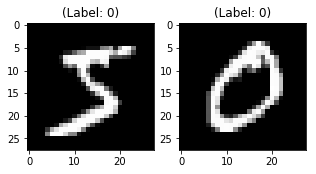

In [4]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train[0], (28,28))
curr_lbl = np.argmax(y_train[0])
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(np.argmax(y_train[0])) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_train[1], (28,28))
curr_lbl = np.argmax(y_train[1])
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(np.argmax(y_train[1])) + ")")

In [3]:
def show_image(image,label):
    # Display the first image in testing data
    plt.figure(figsize=[5,5])
    plt.subplot(122)
    curr_img = np.reshape(image, (40,40))
    plt.imshow(curr_img, cmap='gray')
    plt.title("(Label: " + str(label) + ")")

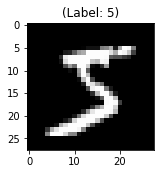

In [6]:
show_image(x_train[0],y_train[0])

In [7]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((-1,28,28,1))
x_test = x_test.reshape((-1,28,28,1))

y_train = tf.one_hot(y_train,10)
y_test = tf.one_hot(y_test,10)
with tf.Session() as sess:
    y_train = sess.run(y_train)
    y_test = sess.run(y_test)


In [4]:
training_iters = 100
learning_rate = 0.001 
batch_size = 128

In [5]:
# MNIST data input (img shape: 28*28)
n_input = 40

# MNIST total classes (0-9 digits)
n_classes = 2

In [6]:
#both placeholders are of type float
x = tf.placeholder("float", [None, n_input,n_input,1])
y = tf.placeholder("float", [None,n_classes])


In [7]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [8]:

weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(2), initializer=tf.contrib.layers.xavier_initializer()),
}

In [9]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)


    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [10]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [11]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

prediction = tf.argmax(pred, 1)

#calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
# Initializing the variables
init = tf.global_variables_initializer()

In [13]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(x_train)//batch_size):
            batch_x = x_train[batch*batch_size:min((batch+1)*batch_size,len(x_train))]
            batch_y = y_train[batch*batch_size:min((batch+1)*batch_size,len(y_train))]    
#             batch_x,batch_y = dataset.get_batch(batch_size)
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")

        # Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss, pred = sess.run([accuracy,cost,prediction], feed_dict={x: x_test,y : y_test})
        pred_t = sess.run(prediction, feed_dict={x: x_train,y : y_train})
        
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(metrics.roc_auc_score(np.argmax(y_test,1),pred)))
        print("Training Accuracy:","{:.5f}".format(metrics.roc_auc_score(np.argmax(y_train,1),pred_t)))
        show_image(x_test[0],pred[0])
        
    summary_writer.close()

InvalidArgumentError: logits and labels must be broadcastable: logits_size=[200,2] labels_size=[128,2]
	 [[Node: softmax_cross_entropy_with_logits = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](softmax_cross_entropy_with_logits/Reshape, softmax_cross_entropy_with_logits/Reshape_1)]]

Caused by op 'softmax_cross_entropy_with_logits', defined at:
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-02c1efad3c4b>", line 3, in <module>
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1873, in softmax_cross_entropy_with_logits_v2
    precise_logits, labels, name=name)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 7169, in softmax_cross_entropy_with_logits
    name=name)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): logits and labels must be broadcastable: logits_size=[200,2] labels_size=[128,2]
	 [[Node: softmax_cross_entropy_with_logits = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](softmax_cross_entropy_with_logits/Reshape, softmax_cross_entropy_with_logits/Reshape_1)]]


In [22]:
np.argmax(y_test,1)[:800]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,